## ECSE415 - Into to Computer Vision
## Assignment 3
### Alexander Harris - 260688155

## 2 - Stereo Vision
### 2.2 - Epipolar Geometry

In [10]:
import cv2
import numpy as np
import sys
import re
import math
import time
from struct import *
from matplotlib import pyplot as plt

def read_pfm(file):
    # Adopted from https://stackoverflow.com/questions/37073108/how-to-read-pfm-files-provided-with-middlebury-dataset?rq=1
    with open(file, "rb") as f:
        # Line 1: PF=>RGB (3 channels), Pf=>Greyscale (1 channel)
        type = f.readline().decode('latin-1')
        if "PF" in type:
            channels = 3
        elif "Pf" in type:
            channels = 1
        else:
            sys.exit(1)
        # Line 2: width height
        line = f.readline().decode('latin-1')
        width, height = re.findall('\d+', line)
        width = int(width)
        height = int(height)

        # Line 3: +ve number means big endian, negative means little endian
        line = f.readline().decode('latin-1')
        BigEndian = True
        if "-" in line:
            BigEndian = False
        # Slurp all binary data
        samples = width * height * channels;
        buffer = f.read(samples * 4)
        # Unpack floats with appropriate endianness
        if BigEndian:
            fmt = ">"
        else:
            fmt = "<"
        fmt = fmt + str(samples) + "f"
        img = unpack(fmt, buffer)
        img = np.flipud(np.array(img).reshape(height, width))
    return img.astype(np.uint8)

In [11]:
def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    # img1 shape
    row, col = img1.shape
    # convert from grayscale to BGR
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [col, -(r[2]+r[0]*col)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

In [14]:
# Import left and right images
imgL = cv2.imread('./im0.png', 0)
imgR = cv2.imread('./im1.png', 0)

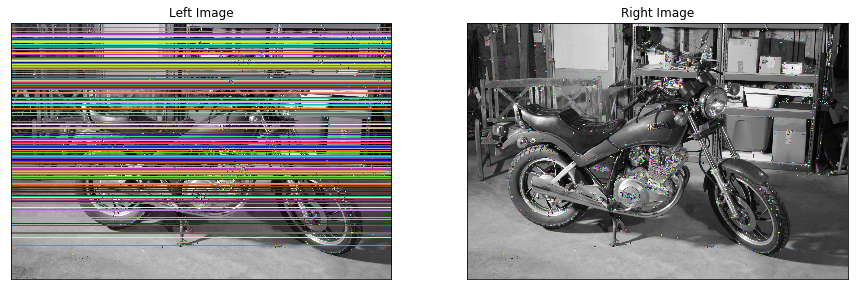

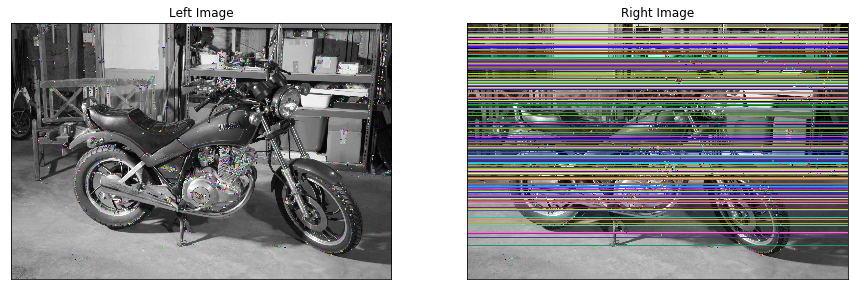

In [138]:
sift = cv2.xfeatures2d.SIFT_create()
bfMatcher = cv2.BFMatcher(cv2.NORM_L2)

# Compute SIFT keypoints and descriptors
kpL, desL = sift.detectAndCompute(imgL, None)
kpR, desR = sift.detectAndCompute(imgR, None)

matches = bfMatcher.knnMatch(desL, desR, k=2)

good = []
ptsL = []
ptsR = []
bad = []
ptsL_bad = []
ptsR_bad = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.6 * n.distance:
        good.append(m)
        ptsR.append(kpR[m.trainIdx].pt)
        ptsL.append(kpL[m.queryIdx].pt)
    else:
        bad.append(m)
        ptsR_bad.append(kpR[m.trainIdx].pt)
        ptsL_bad.append(kpL[m.queryIdx].pt)

ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)
ptsL_bad = np.int32(ptsL_bad)
ptsR_bad = np.int32(ptsR_bad)

F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_LMEDS)

ptsL = ptsL[mask.ravel() == 1]
ptsR = ptsR[mask.ravel() == 1]

linesL = cv2.computeCorrespondEpilines(ptsR, 2, F)
linesL = linesL.reshape(-1, 3)

imgL1, imgR1 = drawlines(imgL, imgR, linesL, ptsL, ptsR)

linesR = cv2.computeCorrespondEpilines(ptsL, 1, F)
linesR = linesR.reshape(-1, 3)

imgR2, imgL2 = drawlines(imgR, imgL, linesR, ptsR, ptsL)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL1, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL2, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR2, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

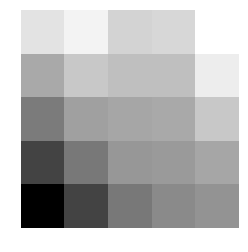

In [105]:
# Implement proper method for finding pointR
# Check every line in left image to find point and line to use
pointR = ptsR_bad[0]
patchR = imgR[pointR[0]:pointR[0]+5, pointR[1]:pointR[1]+5]
plt.imshow(patchR, 'gray'), plt.axis('off')
plt.show()

In [119]:
ssd = []
h, w = imgL.shape
for point in ptsL:
    x = point[0]
    y = point[1]
    x1 = x
    x2 = x + 5
    if x2 > h:
        x1 = x - 5
        x2 = x
    y1 = y
    y2 = y + 5
    if y2 > w:
        y1 = y - 5
        y2 = y
    
    patch = imgL[x1:x2, y1:y2]
    if patch.shape != patchR.shape:
        patch = np.resize(patch, patchR.shape)
    sq_diff = (patch - patchR) ** 2
    summ = np.sum(sq_diff)
    pixels = patch.shape[0] * patch.shape[1]
    error = summ / pixels
    ssd.append(error)

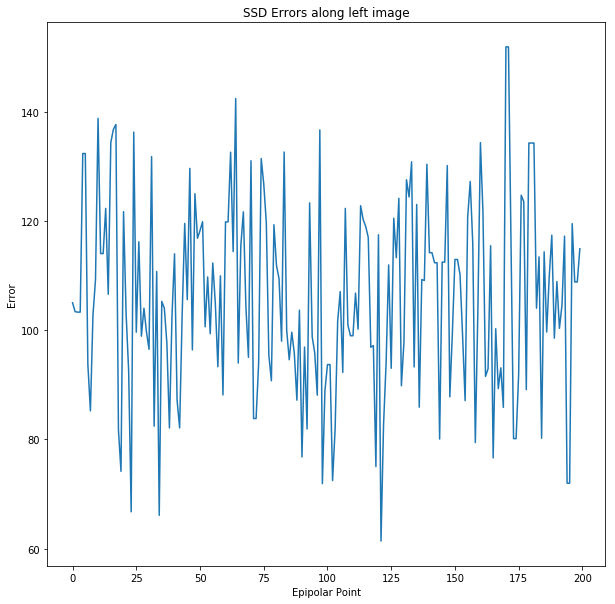

In [126]:
plt.figure(figsize=(10,10))
x = np.arange(len(ssd[0:200]))
plt.plot(x, ssd[0:200])
# plt.xscale('log')
plt.title('SSD Errors along left image')
plt.ylabel('Error')
plt.xlabel('Epipolar Point')
plt.show()

In [135]:
min_ssd = np.argmin(ssd)
min_point = ptsL[min_ssd]
print(min_point)

[ 806 1183]
